# Ancestry informative markers in 1000 genomes

Using code adapted from [MendelAimSelection.jl](https://github.com/OpenMendel/MendelAimSelection.jl), we screen for SNPs that are most ancestry informative for chromosome 18 of 1000 genomes data. We use a subset of those SNPs as typed positions to see if chromosome painting result improves. 

In [35]:
using Revise
using MendelImpute
using GeneticVariation
using Random
using VCFTools
using BenchmarkTools
using DataFrames
using CSV
using DelimitedFiles
using JLSO
using StatsBase
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


## Preprocess data

In [2]:
# get sample ID
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/beagle_raw")
vcffile = "chr18.1kg.phase3.v5a.vcf.gz"
reader = VCF.Reader(openvcf(vcffile, "r"))
sampleID = VCF.header(reader).sampleID
close(reader)

In [3]:
# get each sample's population origin, save result in "chr18.1kg.phase3.v5a.ped"
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
sampleID_to_population = Dict{String, String}()
df = DataFrame(Person = String[], Ethnic = String[])
for population in readdir("data/")
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue
        sampleID_to_population[sample] = population
        sample in sampleID && push!(df, (sample, population))
    end
end
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/beagle_raw")
CSV.write("sample.population.ped", df)

"sample.population.ped"

## Run AIM selection

In [10]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/beagle_raw")
pvals = VCFTools.aim_select(vcffile, sampleID_to_population)
writedlm("chr18.aim.pvals", pvals)

In [4]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/beagle_raw")
pvals = vec(readdlm("chr18.aim.pvals"))
aim_rank = ordinalrank(pvals)
DataFrame(pvalues=pvals, rank=aim_rank)

,pvalues,rank
,Float64,Int64
1,7.07206e-70,159948
2,1.0,387698
3,1.0,387699
4,1.0,387700
5,1.0,387701
6,1.0,387702
7,1.0,387703
8,1.0,387704
9,1.0,387705


## Try filtering chrom 18 data top AIM markers 

In [7]:
nrecords("chr18.uniqueSNPs.vcf.gz")

852602

In [16]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/aim_markers")
function filter_and_mask(sampleID_to_population)
    chr = 18
    
    # filter chromosome data for unique snps
    data = "../beagle_raw/chr$chr.1kg.phase3.v5a.vcf.gz"
    full_record_index = .!find_duplicate_marker(data)
    VCFTools.filter(data, full_record_index, 1:nsamples(data), 
        des = "chr$chr.uniqueSNPs.vcf.gz")

    # summarize data
    total_snps = nrecords("chr$chr.uniqueSNPs.vcf.gz")
    samples = nsamples("chr$chr.uniqueSNPs.vcf.gz")

    # generate target panel with all snps
    n = 100
    sample_idx = falses(samples)
    sample_idx[1:n] .= true
    shuffle!(sample_idx)
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
        sample_idx, des = "target.chr$chr.full.vcf.gz", allow_multiallelic=false)

    # also generate reference panel without target samples
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
        .!sample_idx, des = "ref.chr$chr.excludeTarget.vcf.gz", allow_multiallelic=false)

    # generate aim rank
    aim_pvals = VCFTools.aim_select("chr$chr.uniqueSNPs.vcf.gz", sampleID_to_population)
    aim_rank = sortperm(aim_pvals)
    writedlm("chr18.uniqueSNPs.aim.pvals", pvals)

    # generate target file with 100 samples and 50k typed snps with best aim rank
    p = 50000
    record_idx = falses(total_snps)
    [record_idx[aim_rank[i]] = true for i in 1:p] # typed SNPs are top aim markers
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", record_idx, sample_idx, 
        des = "target.chr$chr.typedOnly.aim.vcf.gz", allow_multiallelic=false)

    # unphase and mask 1% entries in target file
    masks = falses(p, n)
    missingprop = 0.001
    for j in 1:n, i in 1:p
        rand() < missingprop && (masks[i, j] = true)
    end
    mask_gt("target.chr$chr.typedOnly.aim.vcf.gz", masks, 
        des="target.chr$chr.typedOnly.aim.masked.vcf.gz", unphase=true)
end
Random.seed!(2020)
@time filter_and_mask(sampleID_to_population)

  1.046155 seconds (10.12 M allocations: 770.411 MiB, 10.99% gc time)


# Chromosome painting

In [19]:
# map population to super-population
pop_to_superpop = Dict{String, String}()

# 5 east asian
pop_to_superpop["CHB"] = "EAS"; pop_to_superpop["JPT"] = "EAS"; pop_to_superpop["CHS"] = "EAS"; 
pop_to_superpop["CDX"] = "EAS"; pop_to_superpop["KHV"] = "EAS"; 

# 5 european
pop_to_superpop["CEU"] = "EUR"; pop_to_superpop["TSI"] = "EUR"; pop_to_superpop["FIN"] = "EUR";
pop_to_superpop["GBR"] = "EUR"; pop_to_superpop["IBS"] = "EAS";

# 7 african
pop_to_superpop["YRI"] = "AFR"; pop_to_superpop["LWK"] = "AFR"; pop_to_superpop["GWD"] = "AFR"; 
pop_to_superpop["MSL"] = "AFR"; pop_to_superpop["ESN"] = "AFR"; pop_to_superpop["ASW"] = "AFR"; 
pop_to_superpop["ACB"] = "AFR"; 

# 4 ad mixed americans
pop_to_superpop["MXL"] = "AMR"; pop_to_superpop["PUR"] = "AMR"; pop_to_superpop["CLM"] = "AMR"; 
pop_to_superpop["PEL"] = "AMR";

# 5 south asian
pop_to_superpop["GIH"] = "SAS"; pop_to_superpop["PJL"] = "SAS"; pop_to_superpop["BEB"] = "SAS"; 
pop_to_superpop["STU"] = "SAS"; pop_to_superpop["ITU"] = "SAS";

In [22]:
# compress reference haplotypes
Random.seed!(2020)
tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
reffile = "ref.chr18.excludeTarget.vcf.gz"
outfile = "ref.chr18.excludeTarget.jlso"
max_d = 1000
@time compress_haplotypes(reffile, tgtfile, outfile, max_d)

# compute each person's phase information
Random.seed!(2020)
tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
reffile = "ref.chr18.excludeTarget.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile=outfile);

importing reference data...100%|████████████████████████| Time: 0:04:09


446.793735 seconds (4.16 G allocations: 369.333 GiB, 14.55% gc time)
Number of threads = 8
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:05


Total windows = 865, averaging ~ 482 unique haplotypes per window.

Timings: 
    Data import                     = 12.3842 seconds
        import target data             = 1.07618 seconds
        import compressed haplotypes   = 11.308 seconds
    Computing haplotype pair        = 6.77409 seconds
        BLAS3 mul! to get M and N      = 0.104394 seconds per thread
        haplopair search               = 1.75575 seconds per thread
        initializing missing           = 0.00976133 seconds per thread
        allocating and viewing         = 0.0781036 seconds per thread
        index conversion               = 0.00117409 seconds per thread
    Phasing by win-win intersection = 1.94085 seconds
        Window-by-window intersection  = 0.0458773 seconds per thread
        Breakpoint search              = 0.551974 seconds per thread
        Recording result               = 0.0934021 seconds per thread
    Imputation                     = 1.66775 seconds
        Imputing missing            

In [29]:
# need compressed reference panel
reffile = "ref.chr18.excludeTarget.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# get sample's ancestry
tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [sampleID_to_population[id] for id in tgtID];

In [32]:
findall(x -> x == "GBR", sample_population)

1-element Array{Int64,1}:
 1

  0.000107 seconds (5 allocations: 688 bytes)
  0.000108 seconds (5 allocations: 688 bytes)
  0.000206 seconds (5 allocations: 688 bytes)


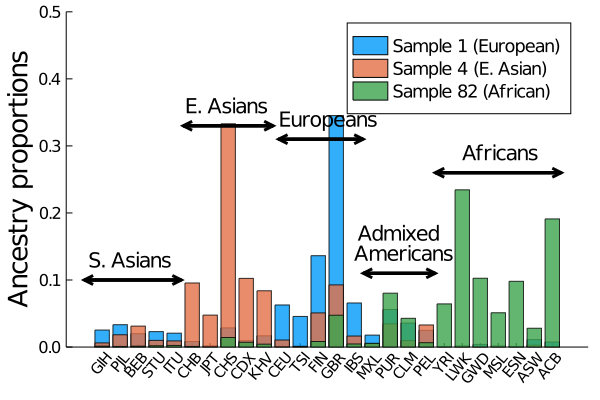

In [36]:
populations = [
    "GIH", "PJL", "BEB", "STU", "ITU",                # 5 south asian
    "CHB", "JPT", "CHS", "CDX", "KHV",                # 5 east asian
    "CEU", "TSI", "FIN", "GBR", "IBS",                # 5 european
    "MXL", "PUR", "CLM", "PEL",                       # 4 ad mixed americans
    "YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB"]  # 7 african

@time sample1_comp = composition(ph[1], panelID, sampleID_to_population, populations=populations)
@time sample4_comp = composition(ph[4], panelID, sampleID_to_population, populations=populations)
@time sample82_comp = composition(ph[82], panelID, sampleID_to_population, populations=populations)

barplot = bar(sample1_comp, xticks=(1:1:26, populations), xrotation=50, grid=false, 
    ylabel = "Ancestry proportions", label="Sample 1 (European)", alpha=0.8, legend=:topright,
    xtickfont=font(10), ytickfont=font(11), legendfont=font(12), yguidefontsize=18,
    ylim = (0, 0.5))
bar!(barplot, sample4_comp, label="Sample 4 (E. Asian)", alpha=0.8)
bar!(barplot, sample82_comp, label="Sample 82 (African)", alpha=0.8)

plot!(barplot, [0, 5.4], [0.1, 0.1], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [5.4, 0], [0.1, 0.1], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 0.3,  0.13 , text("S. Asians", :left))
plot!(barplot, [5.5, 10.5], [0.33, 0.33], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [10.5, 5.5], [0.33, 0.33], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 5.7,  0.36 , text("E. Asians", :left))
plot!(barplot, [10.8, 15.5], [0.31, 0.31], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [15.5, 10.8], [0.31, 0.31], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 10.9,  0.34 , text("Europeans", :left))
plot!(barplot, [15.5, 19.5], [0.11, 0.11], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [19.5, 15.5], [0.11, 0.11], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 15.0, 0.14 , text("Americans", :left))
annotate!(barplot, 15.2, 0.17 , text("Admixed", :left))
plot!(barplot, [19.5, 26.5], [0.26, 0.26], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [26.5, 19.5], [0.26, 0.26], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 21.0, 0.29 , text("Africans", :left))

In [37]:
;open .